# Extending Dan's blog post to ages.

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [51]:
from __future__ import division, print_function
import os
import requests
import pandas as pd
from io import StringIO, BytesIO

def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

In [52]:
import numpy as np

stlr = get_catalog("q1_q16_stellar")

# Select G and K dwarfs.
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))

Selected 91446 targets after cuts


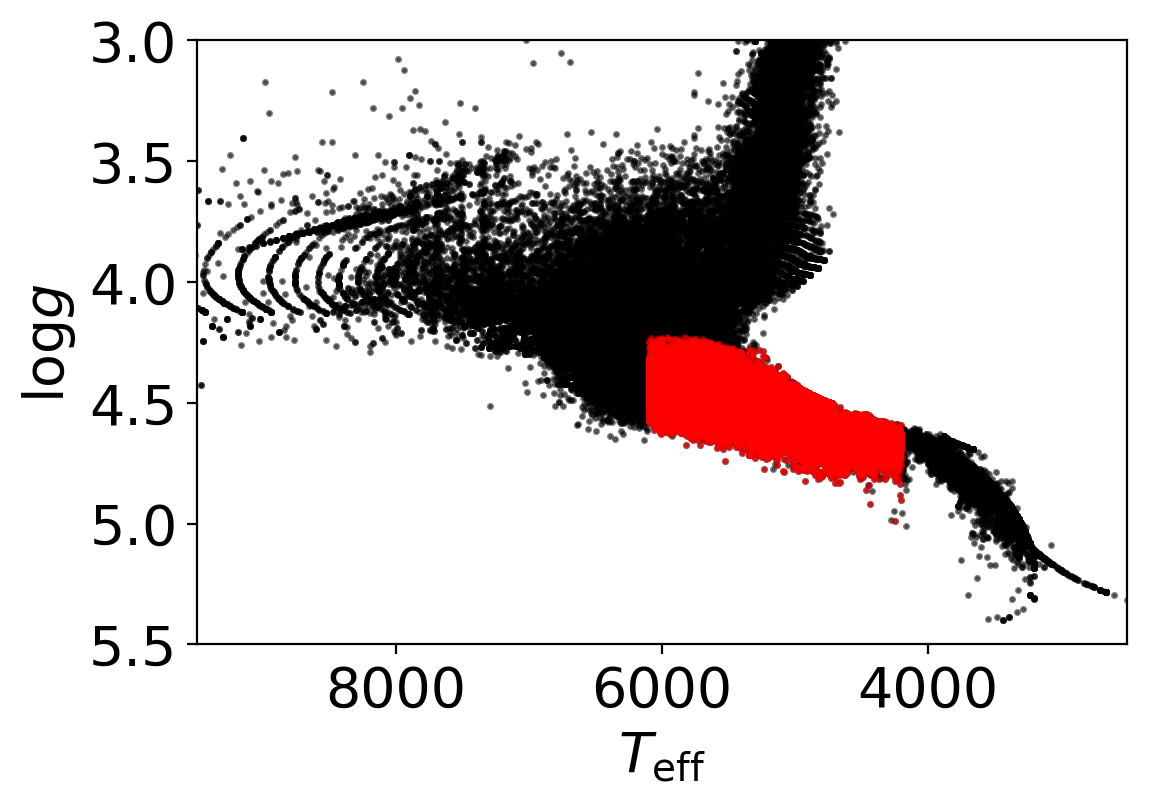

In [53]:
import matplotlib.pyplot as pl

pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");

In [71]:
kois = get_catalog("q1_q16_koi")

period_rng = (50, 300)
rp_rng = (0.75, 2.5)
age_rng = (0, 13.8)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

kois = pd.DataFrame(kois[m])

print("Selected {0} KOIs after cuts".format(len(kois)))

Selected 154 KOIs after cuts


Find the rotation periods of these stars:

In [55]:
#k = []
#for i in kois.kepoi_name:
#    k.append(int(float(i[1:-3])))
#kois["KOI"] = np.array(k)
    
#pdat = pd.read_csv("../data/koi_periods.csv", skiprows=19)
#kps = pd.merge(pdat, kois, on="KOI")

Calculate the colours of these stars

In [56]:
import teff_bv as tbv
kps["bv"] = tbv.teff2bv(kps.teff, kps.logg, kps.feh)

And their ages...

In [57]:
def gyro_age(par, period, bv):
    a, b, c, n = par
    return (period / (a * (bv - c)**b))**(1./n) * 1e-3

In [58]:
par = [.407, .325, .495, .566]
kps["age_gyr"] = gyro_age(par, kps.period, kps.bv)

In [74]:
print(len(kps.age_gyr), len(kps.age_gyr[m]))
m = (np.isfinite(kps.age_gyr)) * (kps.age_gyr < 13.8)
#pl.hist(kps.age_gyr[m]);

51 35


/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


Load the CKS ages.

(array([  83.,  299.,  377.,  365.,  369.,  274.,  147.,   80.,   22.,    9.]),
 array([  1.05196187,   2.39553754,   3.73911321,   5.08268887,
          6.42626454,   7.7698402 ,   9.11341587,  10.45699154,
         11.8005672 ,  13.14414287,  14.48771854]),
 <a list of 10 Patch objects>)

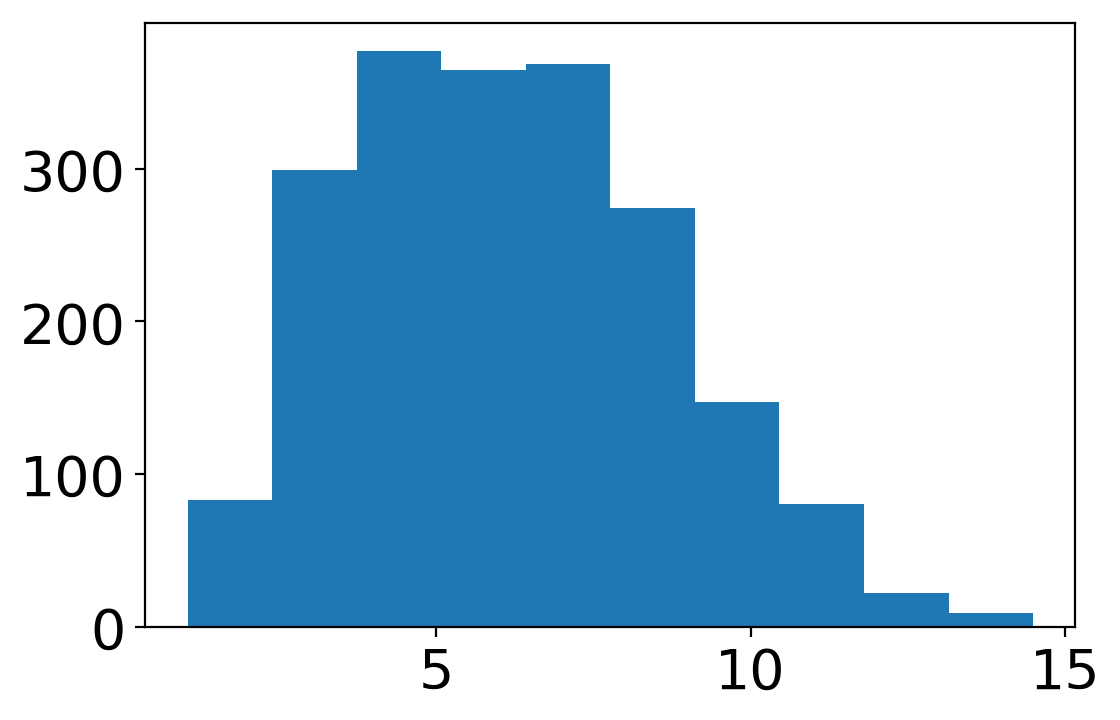

In [60]:
df = pd.read_csv("../data/cks_physical_merged.csv")
pl.hist(df.iso_sage)

In [61]:
nkois = pd.merge(kois, df, on="kepid")

In [68]:
period = np.linspace(period_rng[0], period_rng[1], 57)
rp = np.linspace(rp_rng[0], rp_rng[1], 61)
age = np.linspace(age_rng[0], age_rng[1], 10)
period_grid, rp_grid, age_grid = np.meshgrid(period, rp, age, indexing="ij")
comp = np.zeros_like(period_grid)
for _, star in stlr.iterrows():
    comp += get_completeness(star, period_grid, rp_grid, 0.0, with_geom=True)

In [69]:
from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    return 0.84 * delta_max

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    return pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)

def get_completeness(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

In [70]:
# A double power law model for the population.
def population_model(theta, period, rp, age):
    lnf0, beta, alpha, delta = theta
    v = np.exp(lnf0) * np.ones_like(period)
    for x, rng, n in zip((period, rp, age),
                         (period_rng, rp_rng, age_rng),
                         (beta, alpha, delta)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(kois.koi_prad)
koi_ages = np.array(kois.iso_sage)
vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :] * np.diff(age_grid, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, period_grid, rp_grid) * comp
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model(theta, koi_periods, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [67]:
from scipy.optimize import minimize
theta_0 = np.array([np.log(0.75), -0.53218, -1.5])
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)

NameError: name 'comp' is not defined

In [ ]:
# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        pop[i] = population_model(p, period_grid, rp_grid)
        gamma_earth[i] = population_model(p, 365.25, 1.0) * 365.
        
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * comp[None, :, :], rp, x, period, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Integrate over period.
    dx = 31.25
    x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * comp[None, :, :], 1, 2), period, x, rp, ax)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("\# of detected planets")
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax)
    ax.set_xlim(period_rng[0], period_rng[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$")
    
    return gamma_earth

print(plot_results(r.x));